In [8]:
import json
import re
from joblib import dump
from itertools import chain
from sklearn_crfsuite import CRF
from utils.preprocessing import ner_preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
class PizzaOrderCRFModel:
    def __init__(self):
        self.model = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
        self.labels = ['B-Quantity', 'B-Pizza', 'I-Pizza', 'B-Topping', 'B-Size', 'I-Size', 'O', 'B-Crust', 'I-Crust']
    
    def word2features(self, sentence, i):
        word = sentence[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sentence[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.isupper()': word1.isupper(),
                '-1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['BOS'] = True

        if i < len(sentence)-1:
            word1 = sentence[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['EOS'] = True
            
        return features

    def sentence_features(self, words):
        return [self.word2features(words, i) for i in range(len(words))]

    def sentence_labels(self, labels):
        return labels

    def load_data_from_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return [(
            item['words'], 
            item['label']
        ) for item in data]

    def train(self, data):
        X = [self.sentence_features(s[0]) for s in data]
        y = [self.sentence_labels(s[1]) for s in data]

        self.model.fit(X, y)

    def process_sentence(self, sentence):
        tokens = re.findall(r"[\w']+|[.,!?;]", sentence)
        return {
            "words": tokens,
            "label": ["O"] * len(tokens),
        }

    def predict(self, text):
        processed_sentence = self.process_sentence(text)
        words = processed_sentence["words"]
        features = self.sentence_features(words)

        labels = self.model.predict([features])[0]

        result = {
            "words": words,
            "label": labels,
        }
        return self.aggregate_entities(result)
    
    def predict_with_confidence(self, text):
        processed_sentence = self.process_sentence(text)
        words = processed_sentence["words"]
        features = self.sentence_features(words)

        labels_with_confidence = self.model.predict_marginals([features])[0]

        result = []
        for word, word_labels in zip(words, labels_with_confidence):
            best_label, best_confidence = max(word_labels.items(), key=lambda item: item[1])
            result.append((word, best_label, best_confidence))

        return result

    def aggregate_entities(self, predicted_result):
        aggregated_entities = {}
        current_entity = None
        current_label = None

        for word, label in zip(predicted_result["words"], predicted_result["label"]):
            if label.startswith("B-"):
                if current_entity is not None and current_label is not None:
                    if current_label in aggregated_entities:
                        aggregated_entities[current_label].append(" ".join(current_entity))
                    else:
                        aggregated_entities[current_label] = [" ".join(current_entity)]
                
                current_entity = [word]
                current_label = label[2:] 
            elif label.startswith("I-") and current_entity is not None and label[2:] == current_label:
                current_entity.append(word)
            else:
                if current_entity is not None and current_label is not None:
                    if current_label in aggregated_entities:
                        aggregated_entities[current_label].append(" ".join(current_entity))
                    else:
                        aggregated_entities[current_label] = [" ".join(current_entity)]
                    current_entity = None
                    current_label = None
                if label == "O":
                    continue
                else:
                    aggregated_entities[label] = aggregated_entities.get(label, []) + [word]

        if current_entity is not None and current_label is not None:
            if current_label in aggregated_entities:
                aggregated_entities[current_label].append(" ".join(current_entity))
            else:
                aggregated_entities[current_label] = [" ".join(current_entity)]

        return aggregated_entities

    def save_model(self, file_path):
        dump(self.model, file_path)

    def evaluate(self, test_data, evaluation_type):
        if evaluation_type == 'confusion_matrix':
            self._confusion_matrix(test_data)
        elif evaluation_type == 'classification_report':
            self._classification_report(test_data)
        else:
            raise ValueError("Unsupported evaluation type. Supported types are 'confusion_matrix' and 'classification_report'.")

    def _get_predictions(self, test_data):
        X_test = [self.sentence_features(s[0]) for s in data]
        y_test = [self.sentence_labels(s[1]) for s in data]
        y_pred = self.model.predict(X_test)

        y_test_flat = list(chain.from_iterable(y_test))
        y_pred_flat = list(chain.from_iterable(y_pred))

        return y_test_flat, y_pred_flat

model = PizzaOrderCRFModel()
data = model.load_data_from_json('../data/labeled/entity/order/chatgpt_data.json')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
model.train(train_data)
model.save_model("order_entity_v1.h5")

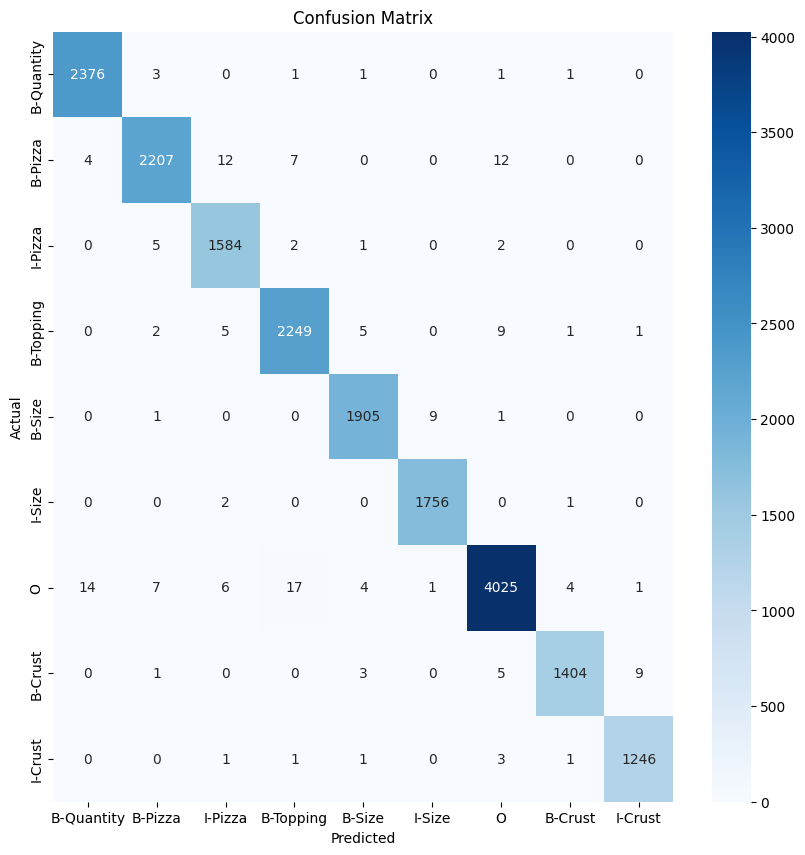

In [3]:
model.evaluate(test_data, 'confusion_matrix')

In [15]:
model.predict(ner_preprocessing("1 hawaiian thêm ớt xanh ái chà nam rôm nữa"))

{'Quantity': ['1'], 'Pizza': ['hawaiian'], 'Topping': ['ớt_xanh', 'nấm_rơm']}